In [1]:
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
DATASET_DIR = "/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset"   # path to your dataset
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
SEED = 42
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [4]:
# Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=train_transforms)

# Calculate sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=train_transforms)

# Calculate sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Important: set transform for val/test
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
model = vit_b_16(weights="IMAGENET1K_V1")

# Replace classifier head
num_features = model.heads.head.in_features
num_classes = len(full_dataset.classes)
model.heads.head = nn.Linear(num_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 208MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [8]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(dataloader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)


In [9]:
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [10]:
best_acc = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_face.pth")


Training: 100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Epoch [1/20] Train Loss: 1.8624 | Train Acc: 0.3722 | Val Loss: 1.1730 | Val Acc: 0.6056


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [2/20] Train Loss: 0.5391 | Train Acc: 0.8611 | Val Loss: 0.7740 | Val Acc: 0.7667


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [3/20] Train Loss: 0.1089 | Train Acc: 0.9819 | Val Loss: 0.6204 | Val Acc: 0.8389


Training: 100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch [4/20] Train Loss: 0.0455 | Train Acc: 0.9917 | Val Loss: 0.8206 | Val Acc: 0.7944


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [5/20] Train Loss: 0.0281 | Train Acc: 0.9965 | Val Loss: 0.5605 | Val Acc: 0.8389


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [6/20] Train Loss: 0.0051 | Train Acc: 1.0000 | Val Loss: 0.5403 | Val Acc: 0.8444


Training: 100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


Epoch [7/20] Train Loss: 0.0033 | Train Acc: 1.0000 | Val Loss: 0.5310 | Val Acc: 0.8444


Training: 100%|██████████| 45/45 [00:57<00:00,  1.29s/it]


Epoch [8/20] Train Loss: 0.0027 | Train Acc: 1.0000 | Val Loss: 0.5285 | Val Acc: 0.8611


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [9/20] Train Loss: 0.0022 | Train Acc: 1.0000 | Val Loss: 0.5305 | Val Acc: 0.8500


Training: 100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


Epoch [10/20] Train Loss: 0.0019 | Train Acc: 1.0000 | Val Loss: 0.5253 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [11/20] Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.5293 | Val Acc: 0.8444


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [12/20] Train Loss: 0.0015 | Train Acc: 1.0000 | Val Loss: 0.5267 | Val Acc: 0.8500


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [13/20] Train Loss: 0.0013 | Train Acc: 1.0000 | Val Loss: 0.5251 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [14/20] Train Loss: 0.0012 | Train Acc: 1.0000 | Val Loss: 0.5266 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [15/20] Train Loss: 0.0011 | Train Acc: 1.0000 | Val Loss: 0.5263 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [16/20] Train Loss: 0.0010 | Train Acc: 1.0000 | Val Loss: 0.5282 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [17/20] Train Loss: 0.0009 | Train Acc: 1.0000 | Val Loss: 0.5273 | Val Acc: 0.8556


Training: 100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


Epoch [18/20] Train Loss: 0.0009 | Train Acc: 1.0000 | Val Loss: 0.5269 | Val Acc: 0.8611


Training: 100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch [19/20] Train Loss: 0.0008 | Train Acc: 1.0000 | Val Loss: 0.5278 | Val Acc: 0.8611


Training: 100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


Epoch [20/20] Train Loss: 0.0007 | Train Acc: 1.0000 | Val Loss: 0.5275 | Val Acc: 0.8611


In [11]:
model.load_state_dict(torch.load("best_vit_face.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8500


In [12]:
from PIL import Image

def predict_image(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    img = test_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img).argmax(1).item()
    return full_dataset.classes[pred]

print(predict_image("/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/Johnny Depp/001_2288a4f6.jpg"))


Johnny Depp


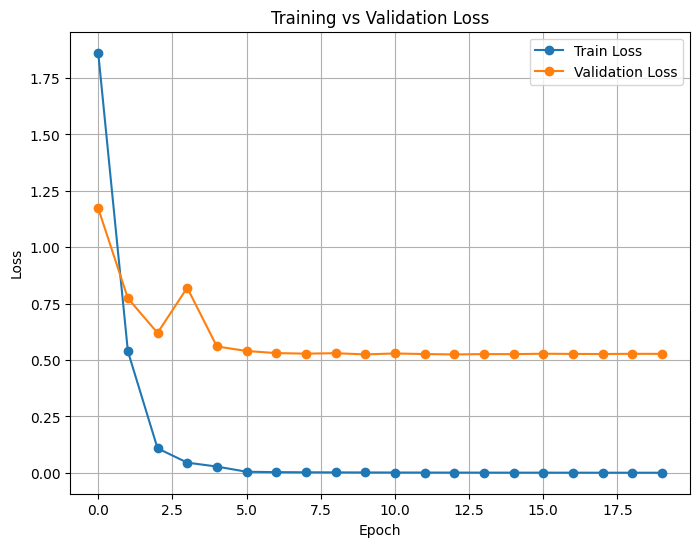

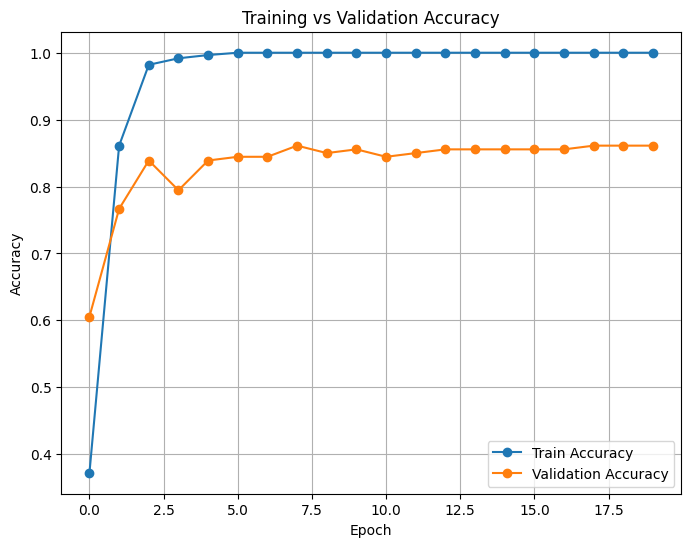

In [13]:
# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
